In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

In [7]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [12]:
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [13]:
data_dir = r'C:\Users\DELL\Downloads\archive\bloodcells_dataset'
filepaths = []
labels = []

In [14]:
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

In [15]:
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [17]:
df

,filepaths,labels
0,C:\Users\DELL\Downloads\archive\bloodcells_dat...,basophil
1,C:\Users\DELL\Downloads\archive\bloodcells_dat...,basophil
2,C:\Users\DELL\Downloads\archive\bloodcells_dat...,basophil
3,C:\Users\DELL\Downloads\archive\bloodcells_dat...,basophil
4,C:\Users\DELL\Downloads\archive\bloodcells_dat...,basophil
...,...,...
10863,C:\Users\DELL\Downloads\archive\bloodcells_dat...,platelet
10864,C:\Users\DELL\Downloads\archive\bloodcells_dat...,platelet
10865,C:\Users\DELL\Downloads\archive\bloodcells_dat...,platelet
10866,C:\Users\DELL\Downloads\archive\bloodcells_dat...,platelet


In [18]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)


In [19]:
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [20]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8694 validated image filenames belonging to 6 classes.
Found 1304 validated image filenames belonging to 6 classes.
Found 870 validated image filenames belonging to 6 classes.


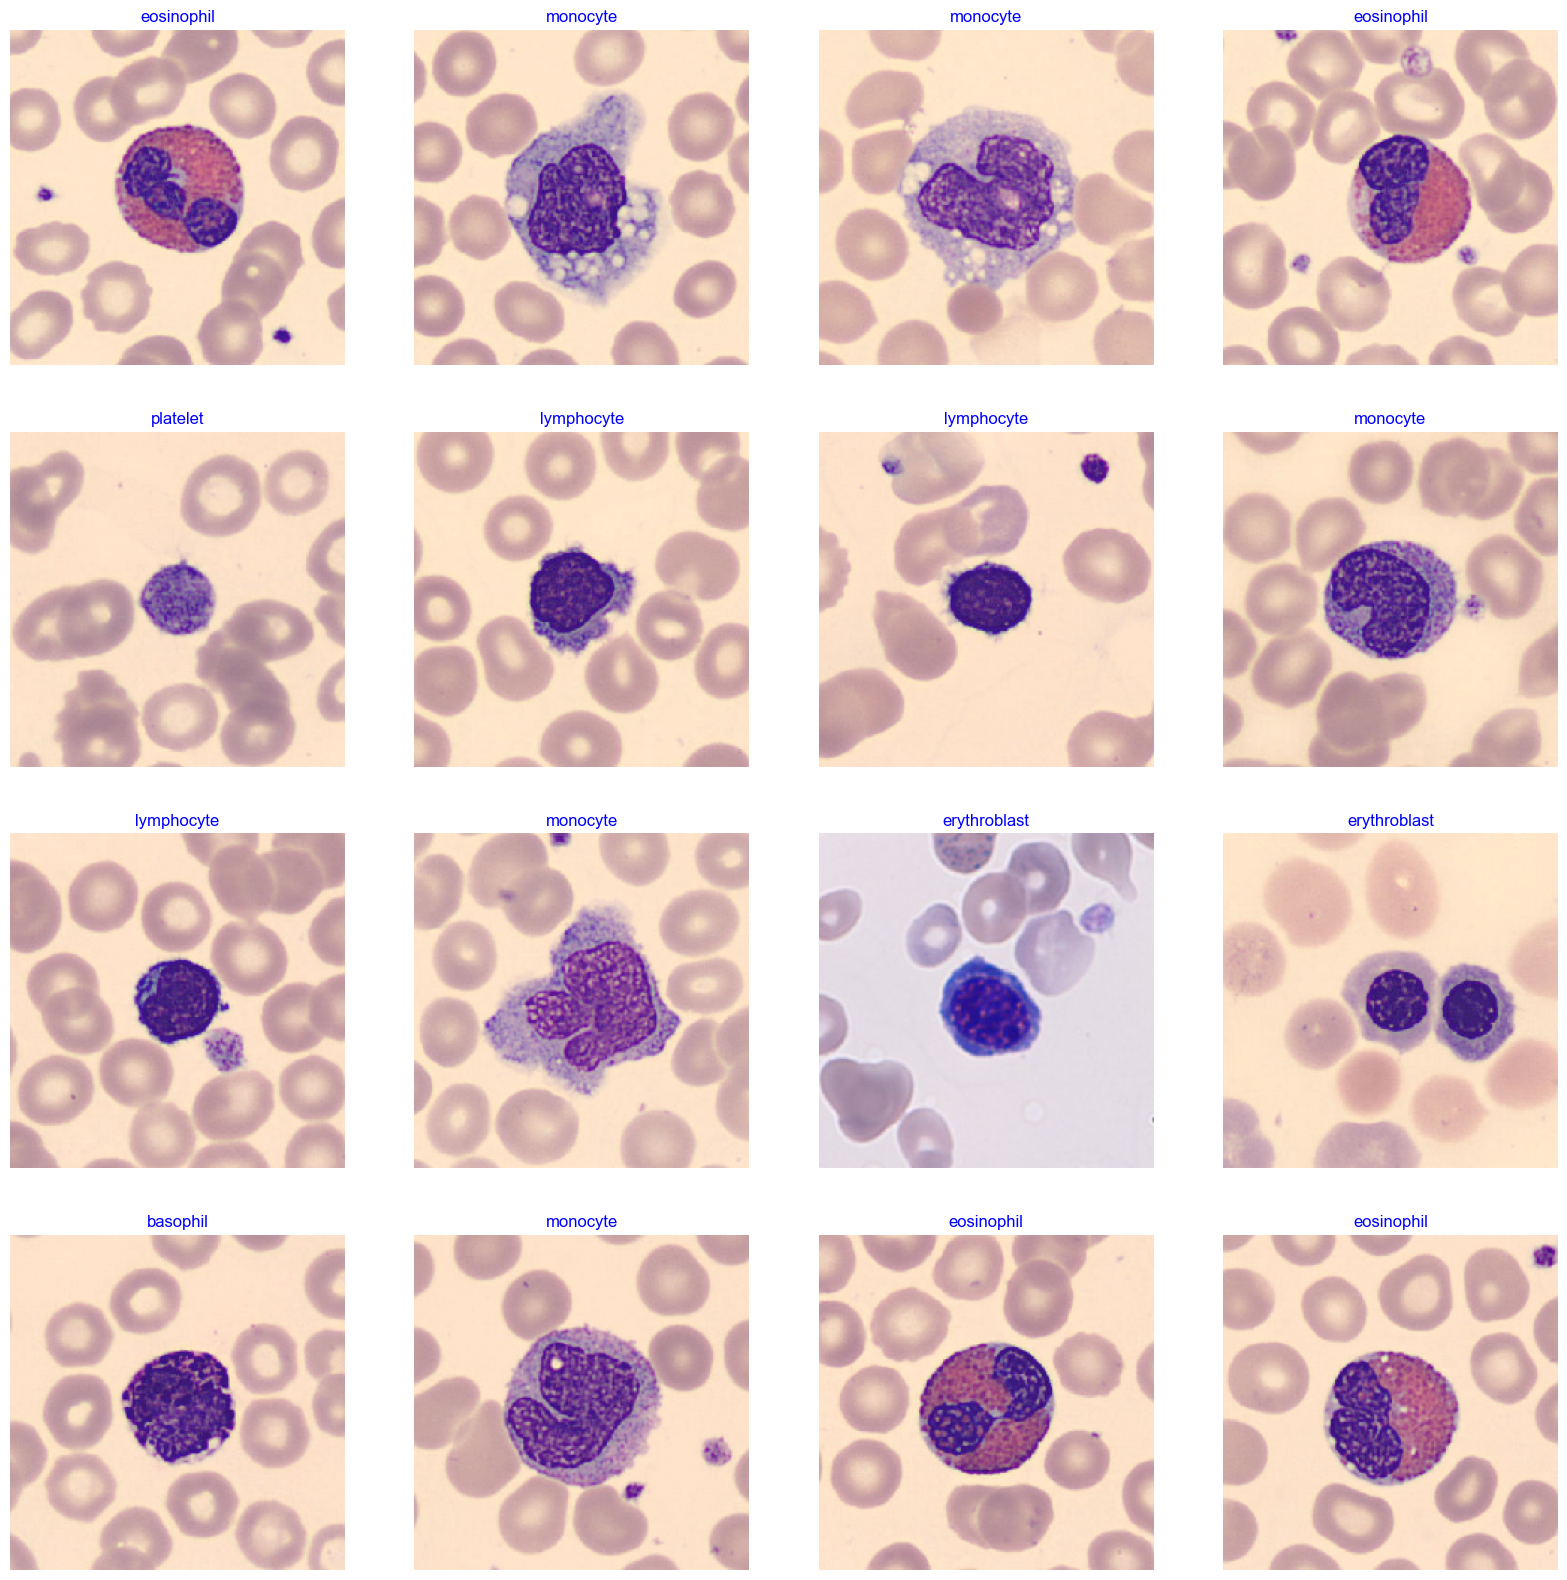

In [21]:
g_dict = train_gen.class_indices 
classes = list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [22]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
   Dense(256, kernel_regularizer=regularizers.l2(0.016), 
      activity_regularizer=regularizers.l1(0.006),
      bias_regularizer=regularizers.l1(0.006), activation='relu'),

    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2592582 (9.89 MB)
Trainable params: 255591

In [23]:
epochs = 7   

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/7
544/544 [==============================] - 4841s 9s/step - loss: 4.7422 - accuracy: 0.9382 - val_loss: 3.8218 - val_accuracy: 0.6879
Epoch 2/7
544/544 [==============================] - 1198s 2s/step - loss: 1.4881 - accuracy: 0.9801 - val_loss: 1.4591 - val_accuracy: 0.8305
Epoch 3/7
544/544 [==============================] - 1133s 2s/step - loss: 0.5615 - accuracy: 0.9877 - val_loss: 0.3560 - val_accuracy: 0.9885
Epoch 4/7
544/544 [==============================] - 5145s 9s/step - loss: 0.3199 - accuracy: 0.9880 - val_loss: 0.3119 - val_accuracy: 0.9693
Epoch 5/7
544/544 [==============================] - 1151s 2s/step - loss: 0.2533 - accuracy: 0.9883 - val_loss: 0.2176 - val_accuracy: 0.9893
Epoch 6/7
544/544 [==============================] - 1102s 2s/step - loss: 0.2004 - accuracy: 0.9932 - val_loss: 0.1900 - val_accuracy: 0.9885
Epoch 7/7
544/544 [==============================] - 1100s 2s/step - loss: 0.1742 - accuracy: 0.9949 - val_loss: 0.1640 - val_accuracy: 0.9931

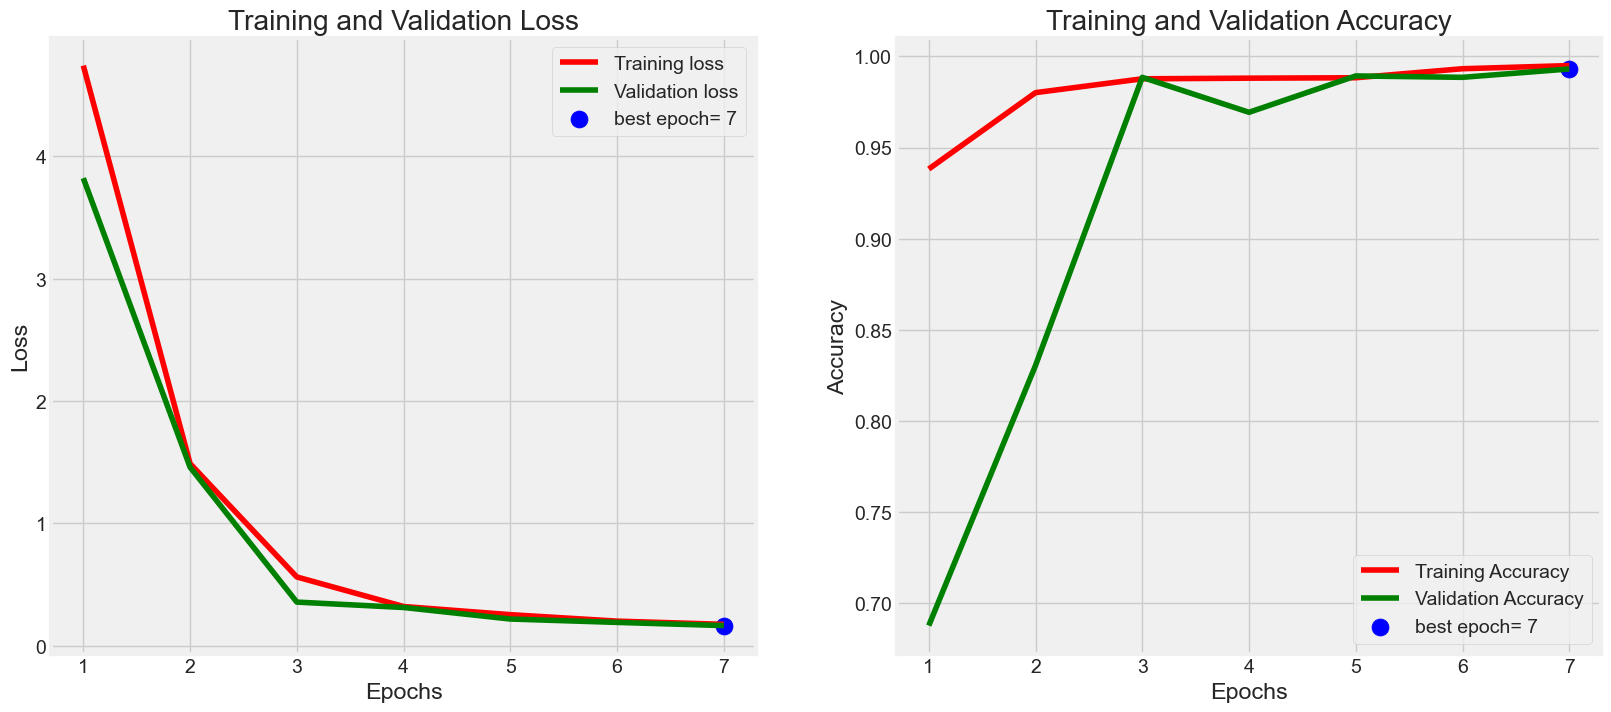

In [24]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [25]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 6s 414ms/step - loss: 0.1420 - accuracy: 0.9958
Train Loss:  0.14756670594215393
Train Accuracy:  0.9958333373069763
--------------------
Validation Loss:  0.17170915007591248
Validation Accuracy:  0.987500011920929
--------------------
Test Loss:  0.1419757455587387
Test Accuracy:  0.9958333373069763


In [26]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

55/55 [==============================] - 23s 395ms/step


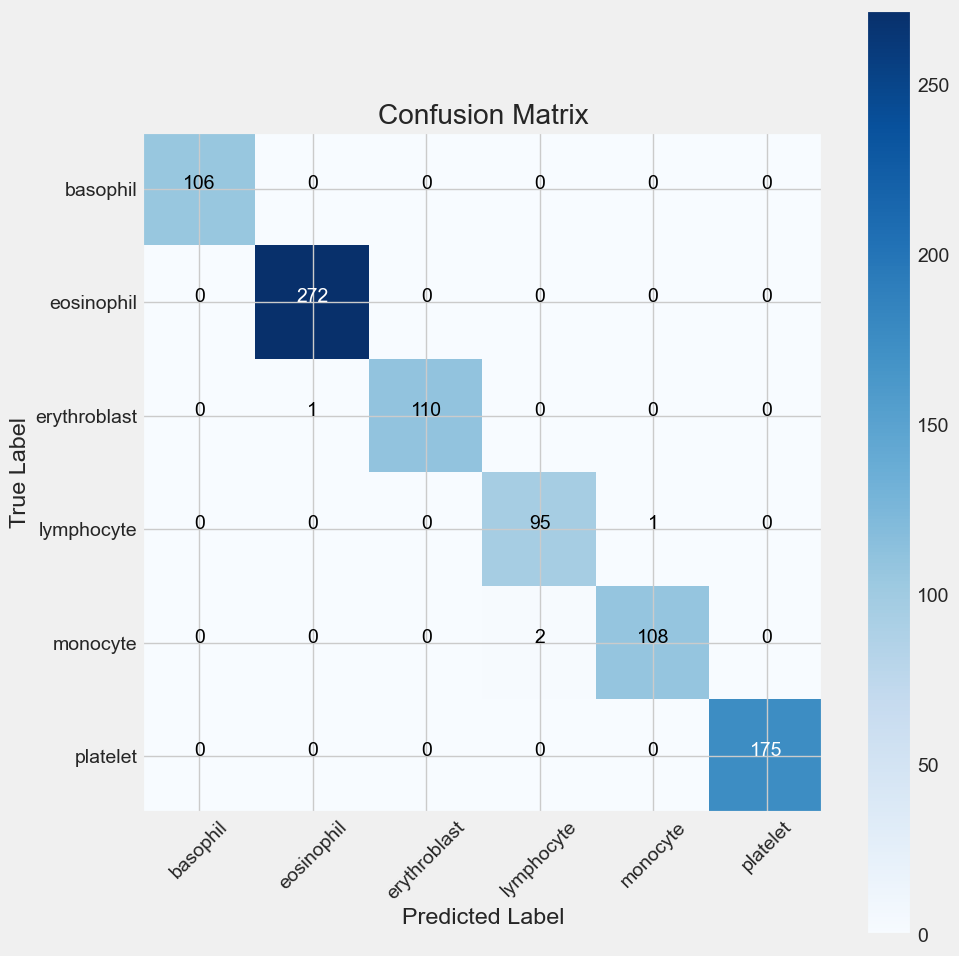

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       1.00      1.00      1.00       106
  eosinophil       1.00      1.00      1.00       272
erythroblast       1.00      0.99      1.00       111
  lymphocyte       0.98      0.99      0.98        96
    monocyte       0.99      0.98      0.99       110
    platelet       1.00      1.00      1.00       175

    accuracy                           1.00       870
   macro avg       0.99      0.99      0.99       870
weighted avg       1.00      1.00      1.00       870

